# ESTIMATION OF TAX EXPENDITURES

In general, the purpose of tax expenditures is to support certain economic sectors and activities, certain social
groups, etc., and it is important to note that there is no unified definition of tax expenditures in the literature.
According to the World Bank, an example of tax expenditures, in a broader context, are tax provisions that
deviate from a normative or a specific tax system and may take a number of forms: exemptions, allowances,
deductions, rebates, credits, preferential tax rates or tax deferrals (WB 2006). According to the Organisation
for Economic Cooperation and Development (OECD), a tax expenditure is a transfer of public resources
that is achieved by reducing tax obligations with respect to a benchmark tax (i.e., the standard tax system),
rather than by a direct expenditure. Due to the fact that there is no single definition of tax expenditure that
is applied everywhere, most countries use the definition of tax expenditure of the OECD. Tax expenditures
may occur in various forms (e.g. exemption, relief, deductions, credit, etc.), which can be delivered through several types
of direct and indirect taxes. Their provision is usually based on a specific goal that should be achieved, and
those benefiting can be natural persons and legal entities.

In order to estimate tax expenditure it is crucial to have a robust micro-simulation model which can have the possibility to estimate tax expenditures through different groups of taxpayers.

In [11]:
options(warn=-1)
library(tidyverse)
library(ggQC)
library(data.table)
options(scipen = 999) # switch off scientific notation


# 1. Creating syntetic data for estimation of tax expenditures     

In [2]:
# Creating articial data for simulation      
SOURCE_DATA_WAGES<-data.frame(stringsAsFactors = FALSE, # Prevent to factors
                                              m = as.integer(runif(10000, 1, 13)),
                                              id = as.integer(runif(10000, 1, 1000000)),
                           nace = sample(x=c("01","02","03","B","10-12","13-15","16","17","18","19","20","21",   
                                                       "22","23","24","25","26","27","28","29","30","31-32","33","35","F","45","46","47",
                                                       "49","50","52","53","I","58","59-60","61","62-63","64","66","68B","69-70","71","73",
                                                        "74-75","77","79","80-82","85","86","87-88","90-92","93","94","95","96","T","36","65","51"),
                                            prob = c(0.0169,0.0169,0.0169,0.0169,0.0169,0.0169,0.0169,	
                                                        0.0169,0.0169,0.0169,0.0169,0.0169,0.0169,0.0169,
                                                        0.0169,0.0169,0.066,0.0169,0.0169,0.0169,0.0169,
                                                        0.0169,0.0169,0.0169,0.0169,0.0332,0.0169,0.0169,
                                                        0.0169,0.0169,0.0169,0.0169,0.0169,0.0169,0.0169,
                                                        0.0169,0.0169,0.0169,0.0169,0.0169,0.0169,0.0169,
                                                        0.0169,0.0169,0.0169,0.0169,0.0169,0.015,0.0158,
                                                        0.0169,0.0169,0.0169,0.0169,0.0169,0.012,0.01,0.001,0.001,0.001),size=10000,replace=TRUE),
                             yearofbirth = as.integer(runif(10000, 1957, 2003)),
                             typeofincome = sample(x=c("1","2","3"), prob = c(.5, .3,.2),size=10000,replace=TRUE),
                             sex = sample(x=c("M","F"), prob = c(.6, .4),size=10000,replace=TRUE),
                             gross_i = abs(rnorm(runif(10000, 18000, 10000000), mean = 350000, sd = 700000)),
                            personal_allowance = as.double(sample(x=c(0,8000), prob = c(.1, .9),size=10000,replace=TRUE)))%>%
dplyr::mutate(ssc = gross_i*0.275,pit = (gross_i-(ssc+personal_allowance))*0.10)
# Introduce Tax expenditures in data
SOURCE_DATA_WAGES$pit[sample(nrow(SOURCE_DATA_WAGES),500)] <- 0
SOURCE_DATA_WAGES$ssc[sample(nrow(SOURCE_DATA_WAGES),500)] <- 0
SOURCE_DATA_WAGES<-SOURCE_DATA_WAGES%>%
dplyr::mutate( net_i = gross_i-(ssc+pit))%>%
data.table()

In [3]:
str(SOURCE_DATA_WAGES)

Classes 'data.table' and 'data.frame':	10000 obs. of  11 variables:
 $ m                 : int  7 8 10 1 6 4 6 8 2 4 ...
 $ id                : int  605124 152518 551521 580753 686789 375703 208113 965646 910320 439758 ...
 $ nace              : chr  "13-15" "90-92" "45" "19" ...
 $ yearofbirth       : int  1973 2001 1981 1996 1989 1970 1966 1988 2000 1975 ...
 $ typeofincome      : chr  "2" "1" "2" "1" ...
 $ sex               : chr  "F" "M" "M" "M" ...
 $ gross_i           : num  1312839 75781 331424 789974 250600 ...
 $ personal_allowance: num  8000 8000 8000 8000 8000 0 8000 8000 8000 8000 ...
 $ ssc               : num  0 20840 91141 217243 68915 ...
 $ pit               : num  94381 4694 23228 56473 17369 ...
 $ net_i             : num  1218458 50247 217054 516258 164317 ...
 - attr(*, ".internal.selfref")=<externalptr> 


# 2. Defining a simple function for detecting tax expenditures

In [4]:
detectig_TE <- function(typeofincome){
                  taxexpenditures=if_else(typeofincome %in% c("2","3"),"Yes","No")
                  return(as.character(taxexpenditures))
                }

In [5]:
Estimated_TE<-mutate(SOURCE_DATA_WAGES,
                    TE=detectig_TE(typeofincome)
                    )

In [6]:
head(Estimated_TE)

m,id,nace,yearofbirth,typeofincome,sex,gross_i,personal_allowance,ssc,pit,net_i,TE
7,605124,13-15,1973,2,F,1312838.61,8000,0.00,94380.799,1218457.81,Yes
8,152518,90-92,2001,1,M,75780.81,8000,20839.72,4694.109,50246.98,No
10,551521,45,1981,2,M,331423.58,8000,91141.49,23228.210,217053.89,Yes
1,580753,19,1996,1,M,789973.75,8000,217242.78,56473.097,516257.87,No
6,686789,03,1989,3,M,250600.48,8000,68915.13,17368.535,164316.81,Yes
4,375703,F,1970,1,M,478238.92,0,131515.70,34672.322,312050.90,No


In [7]:
TE_TABLE_GROUP<-Estimated_TE%>%
dplyr::filter(TE=="Yes")%>%
dplyr::select(nace,pit)%>%
dplyr::group_by(nace)%>%
dplyr::summarise(value=sum(pit))%>%
dplyr::top_n(10) 

Selecting by value


In [8]:
head(TE_TABLE_GROUP)

nace,value
03,3958682
19,3975569
22,4099153
26,14040679
45,6416841
49,4521963


In [9]:
summary(TE_TABLE_GROUP)

     nace               value         
 Length:10          Min.   : 3958682  
 Class :character   1st Qu.: 4032890  
 Mode  :character   Median : 4402893  
                    Mean   : 5448330  
                    3rd Qu.: 4620861  
                    Max.   :14040679  

# 3. Plotting Pareto plot (TOP-10 TE's)

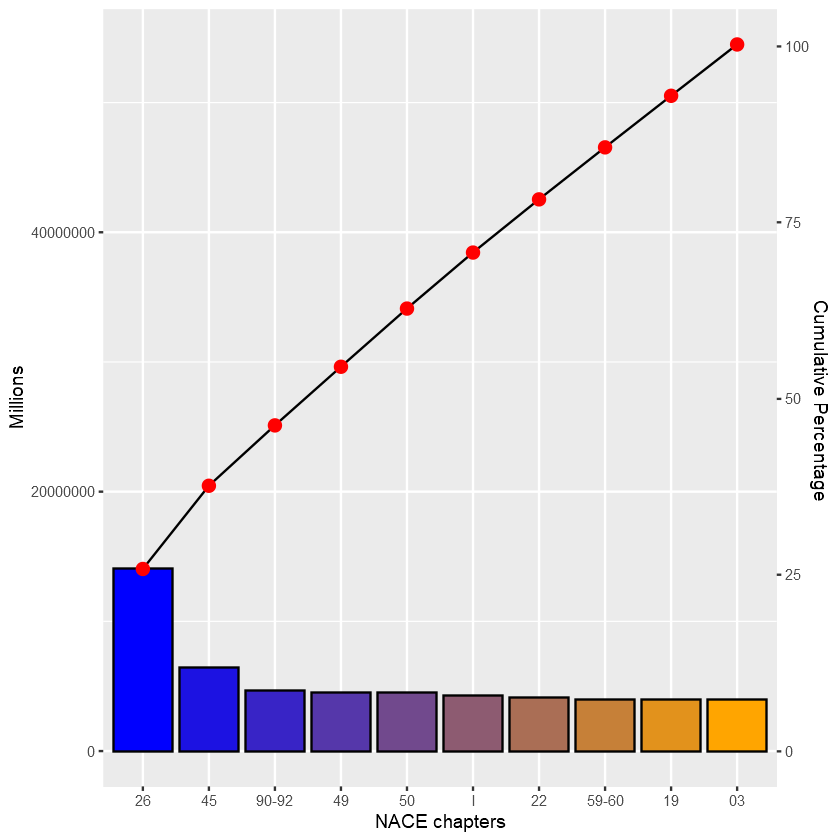

In [10]:
ggplot(TE_TABLE_GROUP, aes(x=nace, y=value)) +
  stat_pareto(point.color = "red",
              point.size = 3,
              line.color = "black",
              size.line = 1,
              bars.fill = c("blue", "orange")
  )+
  xlab('NACE chapters') +
  ylab('Millions')